!pip install git+https://github.com/DeepTrackAI/deeplay

# Image super-resolution with DDPM

We'll build a denoising diffusion probabilistic model (DDPM) for converting low-resolution images to high-resolution images.

## The BioSR dataset

We will use the BioSR dataset from the resource: [BioSR: a biological image dataset for super-resolution microscopy](https://figshare.com/articles/dataset/BioSR/13264793). BioSR is a biological image dataset for super-resolution microscopy. It contains low-resolution and high resolution images of four biological structures: Clathrin-coated pits (CCPs), endoplasmic reticulum (ER), microtubules (MTs), and F-actin filaments (F-actin). For this project, we will use the Microtubules (MTs) images.

We have preprocessed the MTs images from their raw format to a format that can be used for training the model. The processed dataset is available at [biosr_dataset](https://github.com/deeptrackai/biosr_dataset/) GitHub repository. The repository contains 40320 image pairs for training, and 2080 image pairs for validation.

We will download the dataset using the `git clone` command, and then change the current working directory to the `biosr_dataset` directory using the following commands:
    
```bash
    !git clone https://github.com/DeepTrackAI/biosr_dataset.git
    !cd biosr_dataset
```

We will run the above command in the next code cell.

In [1]:
# import os

# if not os.path.exists("biosr_dataset"):
#     os.system("git clone https://github.com/DeepTrackAI/biosr_dataset")

We will create a custom dataset class `BioSRDataset` using the `torch.utils.data.Dataset` class. Once defined, the dataset class can be used like any other PyTorch dataset (e.g., any of the datasets in `torchvision.datasets`). The dataset class enables the use of the PyTorch DataLoader, which automatically handles data loading, shuffling, and batching.

In [2]:
import os
import numpy as np
from torch.utils.data import Dataset
import torch
from tifffile import tifffile

def normalize_uint8(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 255).astype(np.uint8)
    return img

class BioSRDataset(Dataset):
    """Dataset class for lading the BioSR dataset."""

    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train

        if self.train:
            self.low_res_dir = os.path.join(root, "training_wf")
            self.high_res_dir = os.path.join(root, "training_gt")
        else:
            self.low_res_dir = os.path.join(root, "validate_wf")
            self.high_res_dir = os.path.join(root, "validate_gt")

        file_list = os.listdir(self.low_res_dir)
        self.file_list = [file for file in file_list if file.endswith(".tif")]

    def __len__(self):
        """Return the number of low resolution - high resolution image pairs."""
        return len(self.file_list)

    def __getitem__(self, index):
        """Get next low resolution - high resolution image pair."""
        low_res_path = os.path.join(self.low_res_dir, self.file_list[index])
        high_res_path = os.path.join(self.high_res_dir, self.file_list[index])

        low_resolution_image = normalize_uint8(tifffile.imread(low_res_path))
        high_resolution_image = normalize_uint8(tifffile.imread(high_res_path))

        if self.transform:
            seed = np.random.randint(1_000_000_000)

            torch.manual_seed(seed)
            low_resolution_image = self.transform[0](low_resolution_image)

            torch.manual_seed(seed)
            high_resolution_image = self.transform[1](high_resolution_image)

        return low_resolution_image, high_resolution_image

We will define the transforms to be applied to the images using `torchvision.transforms` module. 

The low-resolution images are of size 128x128, and the high-resolution images are of size 256x256. To make the model memory efficient, we will first resize the images to 64x64 and 128x128, respectively. 

In the next step, we will resize the input images (low-resolution images) to 128x128 through bicubic interpolation to match the size of the output image (high-resolution images). This process is required to ensure that the input and output images have the same size while training the model. 

Finally we will normalize the images to have pixel values between -1 and 1, which is a common practice for training DDPM models.

In [3]:
from torchvision import transforms

trans_low_res = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64), antialias=True),
    transforms.Resize((128, 128),
                      interpolation=transforms.InterpolationMode.BICUBIC,
                      antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

trans_high_res = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

We will now use the `BioSRDataset` class to create the training and validation datasets. The dataset folder is passed through the `root`argument, and the transforms are passed through the `transform` argument.

The `train` argument is set to `True` to create the training dataset, and `False` to create the validation dataset.

In [4]:
root = "/data/BioSR/Microtubules" # comment this when running on local machine (uncomment the next line)
# root = os.path.join("biosr_dataset", "BioSR", "Microtubules")

train_dataset = BioSRDataset(root, train=True, 
                             transform=[trans_low_res, trans_high_res])
test_dataset = BioSRDataset(root, train=False,
                           transform=[trans_low_res, trans_high_res])

print(len(train_dataset), len(test_dataset))

40320 2080


We will visualise some images from the training dataset using the `matplotlib` package.

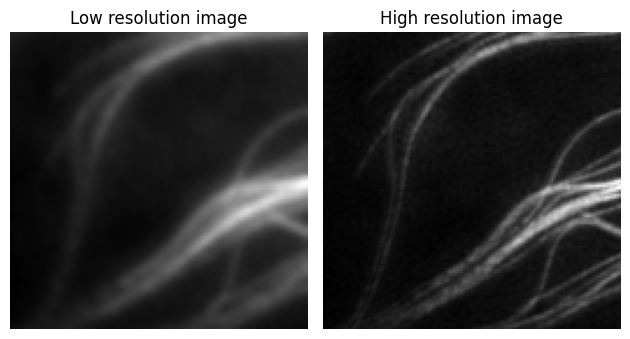

In [5]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# Get a random sample from the training dataset
low_res_image, high_res_image = train_dataset[
    np.random.randint(0, len(train_dataset))]

# Plot the images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(low_res_image.permute(1, 2, 0), cmap='gray')
plt.title('Low resolution image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(high_res_image.permute(1, 2, 0), cmap='gray')
plt.title('High resolution image')
plt.axis('off')
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda:0


## Diffusion process


In this section we will implement the forward and the reverse diffusion processes by defining the `Diffusion` class.

We define the `Diffusion` class with the following methods:
1. `prepare_noise_schedule`: Prepares the noise schedule based on the given `beta_start` and `beta_end` parameters, and the number of steps given by the parameter `noise_steps`.
2. `noise_images`: Implements the forward diffusion process. Given an input image `x`, and the time step `t`, it returns the noisy image `x_t`.
3. `sample_timesteps`: Generates `n` random time steps. This is used during the training process to generate a batch of random time steps for the forward diffusion process.
4. `sample_test_image`: Implements the reverse diffusion process. Generates an image from pure noise.

We will add additional attribute, `input_image`, to the `sample_test_image` method. This will allow us to generate images from image conditioned inputs, unlike in the previous projects, where we generated images by conditioning on class labels and textual inputs.

In [7]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""

    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 img_size=28, device=device):
        """Initialize the diffusion model."""
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

    def reverse_diffusion(self, model, n_images, n_channels,
                          position_encoding_dim, position_encoding_function,
                          fixed_noise=None, save_time_steps=None,
                          input_image=None):
        """Reverse diffusion process"""        
        with torch.no_grad():
            if fixed_noise is not None:
                x = fixed_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                )
                x = x.to(self.device)

            denoised_images = []
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(
                    t.unsqueeze(1), position_encoding_dim
                ).to(self.device)

                if input_image is None:
                    predicted_noise = model(x, t_pos_enc)
                else:
                    predicted_noise = model(
                        torch.cat((input_image.to(self.device), x), dim=1),
                        t_pos_enc,
                    )
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                
                if i > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                    + torch.sqrt(1-alpha) * noise)

                if i in save_time_steps:
                    denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Attention UNet

In this section we will define the Attention UNet that is used in the DDPM model.

We use the class `AttentionUNet` from deeplay to define the Attention UNet architecture. It takes the noisy image and the time step corresponding to the noisy image as input, and returns the noise added to the image as output.

The input channels and output channels are defined the parameters `in_channels` and `out_channels` respectively. The `channels` parameter defines the number of channels in the hidden layers of the UNet, i.e., the number of convolutional filters in the hidden layers.

The `base_channels` parameter defines the number of channels at the base of the UNet, between the encoder and the decoder.

The `channel_attention` parameter can be used to control of attention mechanism that is applied at hidden channels. The boolean values (True or False) defined by the `channel_attention` parameter are used to control the attention mechanism. The first boolean value will be ignored as the time step attention is not included in the first hidden channel. When performing an ablation study, set the attention mechanism to `False` from the end of the list.

The `position_embedding_dim` parameter is used to indicate the dimension of the position encoding of the time step. We will look at it in more detail in the next step.

In [8]:
import deeplay as dl

position_encoding_dim = 64

unet = dl.AttentionUNet(
    in_channels=2, 
    channels=[32, 64, 128],
    base_channels=[256, 256],
    out_channels=1,
    channel_attention=[False, False, False],
    position_embedding_dim=position_encoding_dim,
)
unet.build()
unet.to(device)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttentionUNet(
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): DoubleConvBlock(
          (blocks): LayerList(
            (0): Block(
              (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (normalization): GroupNorm(1, 64, eps=1e-05, affine=True)
              (activation): GELU(approximate='none')
            )
            (1): Block(
              (layer): Co

We will define the position encoding function, `positional_encoding` to convert the time step from a singular value to a position encoding vector. Instead of passing the time step as a singular value, we will pass it as a position encoding vector to the Attention UNet.

In [9]:
def positional_encoding(t, emb_dim):
	inv_freq = 1.0 / (10000 ** (torch.arange(0, emb_dim, 2).float() / emb_dim))
	inv_freq = inv_freq.to(t.device)
	pos_enc_a = torch.sin(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc_b = torch.cos(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
	return pos_enc

### Optimizers

We will define the optimizer and learning rate for the model. We will use the Adam optimizer with a learning rate of 1e-4.

In [10]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

### Loss function

We will use a L1 loss function to train the model.

In [11]:
criterion = torch.nn.L1Loss()

### Data loaders

We now define the data loaders for the training and val datasets. We will use a batch size of `64` as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` for the training data loader to shuffle the training dataset.

In [12]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training procedure

We now define an instance of the `Diffusion` class with 2000 noise steps for training the model. We will use a `beta_start` of 1e-6 and a `beta_end` of 0.01.

In [13]:
noise_steps = 2000

diffusion = Diffusion(
    noise_steps=noise_steps,
    img_size=128,
    beta_start=1e-6,
    beta_end=0.01,
)

We now define a helper function `prepare_data` to prepare the data for training the model. The function takes input image and the target image as inputs, and returns the noise image concatenated with the input image, time step embedding, and the noise added to the target image. The former two are used as inputs to the Attention UNet, and the latter is used as the target for training the model.

In [14]:
def prepare_data(input_image, target_image, device=device):
    """Prepare data."""
    batch_size = input_image.shape[0]

    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    input_image = input_image.to(device) 
    target_image = target_image.to(device) 
    x_t, noise = diffusion.forward_diffusion(target_image, t)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)

    x_t = torch.cat((input_image, x_t), dim=1)

    return x_t.to(device), t.to(device), noise.to(device)


We will define a helper function `denormalize` to denormalize the images for visualisation.

In [15]:
def denormalize(image):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * 0.5 + 0.5
    image = image - image.min()
    image = image / (image.max() - image.min())
    return image

We now define the training loop for the DDPM model for generating high-resolution images from low-resolution images. We will train the model for 30 defined by the `EPOCHS` parameter.

Once every epoch, we will print the losses, time taken for the epoch, and also visualize the generated images.


Epoch 1/30
__________
Batch 1/630: Train loss: 0.9439
Batch 201/630: Train loss: 0.1143
Batch 401/630: Train loss: 0.1032
Batch 601/630: Train loss: 0.0766
----------
Epoch 1/30 : Train loss: 0.1395, Time taken: 0:05:09.519709


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 201.99it/s]


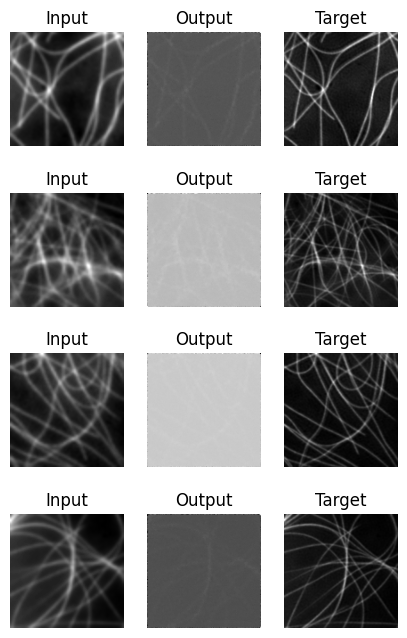


Epoch 2/30
__________
Batch 1/630: Train loss: 0.0797
Batch 201/630: Train loss: 0.0741
Batch 401/630: Train loss: 0.0581
Batch 601/630: Train loss: 0.0563
----------
Epoch 2/30 : Train loss: 0.0828, Time taken: 0:05:12.638483


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.94it/s]


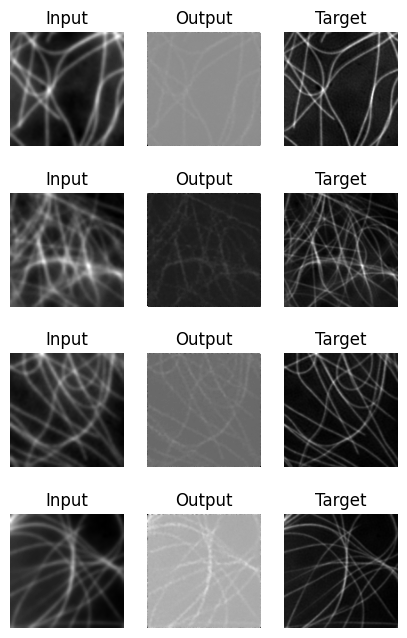


Epoch 3/30
__________
Batch 1/630: Train loss: 0.0918
Batch 201/630: Train loss: 0.0759
Batch 401/630: Train loss: 0.0721
Batch 601/630: Train loss: 0.0676
----------
Epoch 3/30 : Train loss: 0.0729, Time taken: 0:05:12.564981


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 201.95it/s]


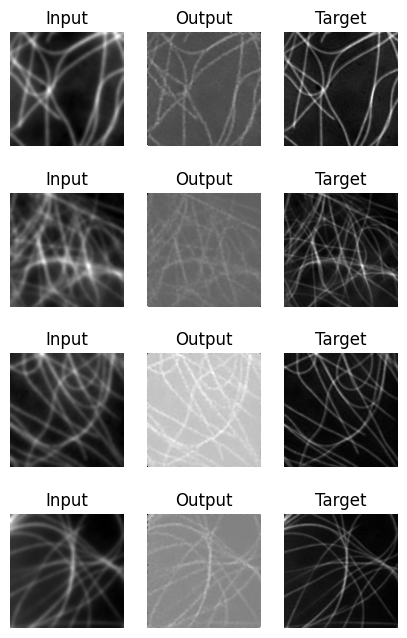


Epoch 4/30
__________
Batch 1/630: Train loss: 0.0642
Batch 401/630: Train loss: 0.0632
Batch 601/630: Train loss: 0.0571
----------
Epoch 4/30 : Train loss: 0.0668, Time taken: 0:05:14.965888


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.55it/s]


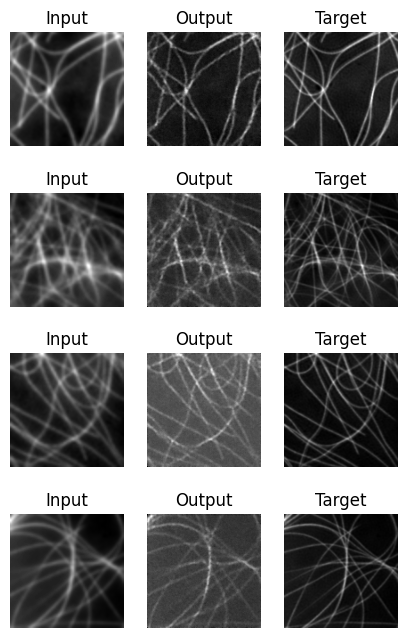


Epoch 5/30
__________
Batch 1/630: Train loss: 0.0474
Batch 201/630: Train loss: 0.0920
Batch 401/630: Train loss: 0.0448
Batch 601/630: Train loss: 0.0613
----------
Epoch 5/30 : Train loss: 0.0611, Time taken: 0:05:14.017081


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.94it/s]


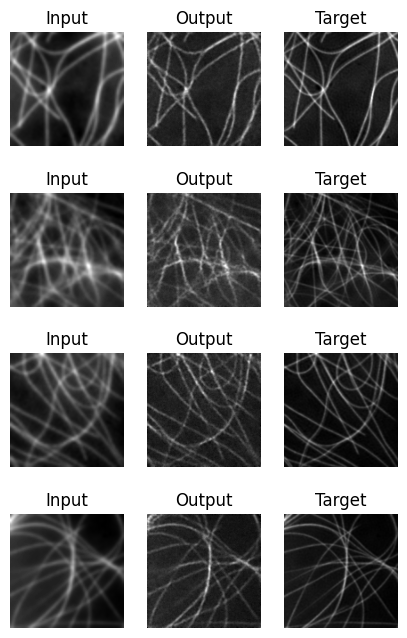


Epoch 6/30
__________
Batch 1/630: Train loss: 0.0413
Batch 201/630: Train loss: 0.0672
Batch 401/630: Train loss: 0.0547
Batch 601/630: Train loss: 0.0551
----------
Epoch 6/30 : Train loss: 0.0568, Time taken: 0:05:13.992569


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.10it/s]


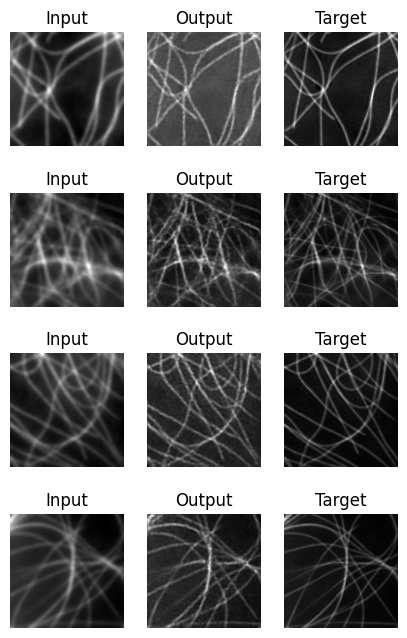


Epoch 7/30
__________
Batch 1/630: Train loss: 0.0449
Batch 201/630: Train loss: 0.0540
Batch 401/630: Train loss: 0.0582
Batch 601/630: Train loss: 0.0529
----------
Epoch 7/30 : Train loss: 0.0545, Time taken: 0:05:12.843376


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 203.33it/s]


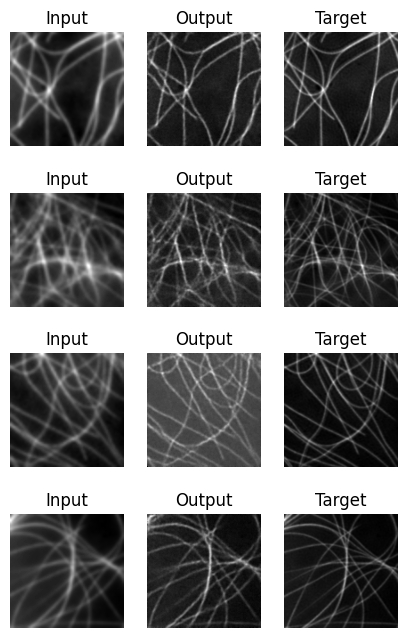


Epoch 8/30
__________
Batch 1/630: Train loss: 0.0305
Batch 201/630: Train loss: 0.0497
Batch 401/630: Train loss: 0.0750
Batch 601/630: Train loss: 0.0585
----------
Epoch 8/30 : Train loss: 0.0533, Time taken: 0:05:13.107481


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 203.27it/s]


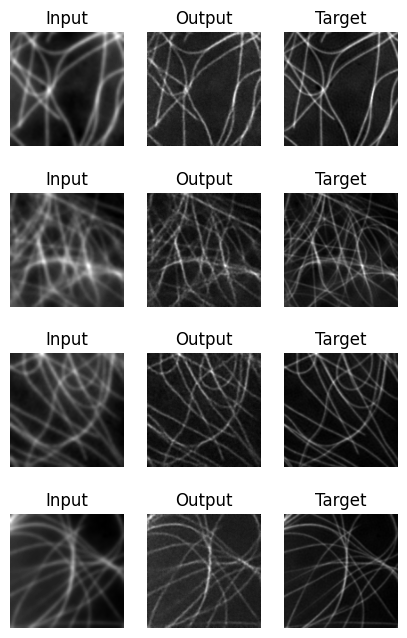


Epoch 9/30
__________
Batch 1/630: Train loss: 0.0508
Batch 201/630: Train loss: 0.0501
Batch 401/630: Train loss: 0.0485
Batch 601/630: Train loss: 0.0879
----------
Epoch 9/30 : Train loss: 0.0517, Time taken: 0:05:14.227365


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.30it/s]


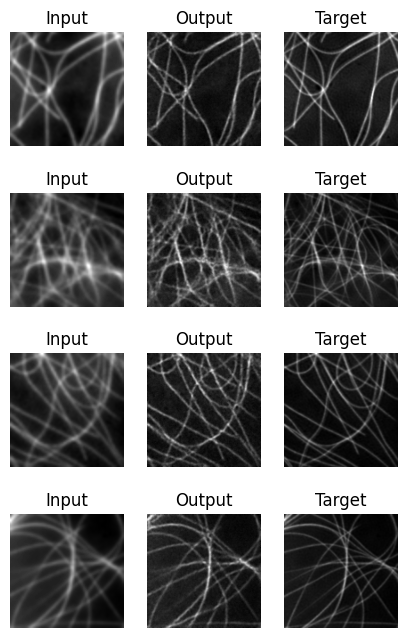


Epoch 10/30
__________
Batch 1/630: Train loss: 0.0528
Batch 201/630: Train loss: 0.0484
Batch 401/630: Train loss: 0.0526
Batch 601/630: Train loss: 0.0523
----------
Epoch 10/30 : Train loss: 0.0502, Time taken: 0:05:14.869743


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 203.07it/s]


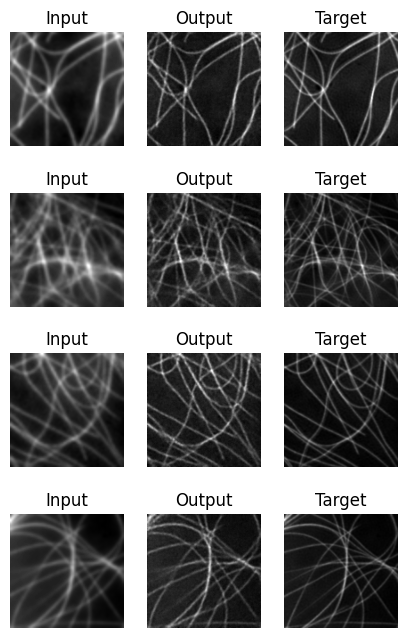


Epoch 11/30
__________
Batch 1/630: Train loss: 0.0375
Batch 201/630: Train loss: 0.0318
Batch 401/630: Train loss: 0.0325
Batch 601/630: Train loss: 0.0494
----------
Epoch 11/30 : Train loss: 0.0491, Time taken: 0:05:15.875359


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.38it/s]


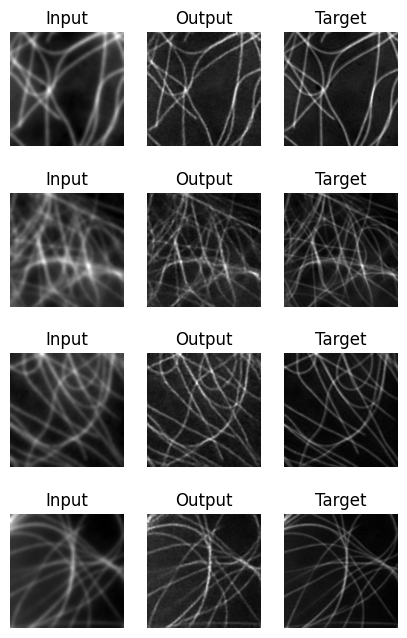


Epoch 12/30
__________
Batch 1/630: Train loss: 0.0457
Batch 201/630: Train loss: 0.0363
Batch 401/630: Train loss: 0.0564
Batch 601/630: Train loss: 0.0432
----------
Epoch 12/30 : Train loss: 0.0481, Time taken: 0:05:15.047253


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 201.91it/s]


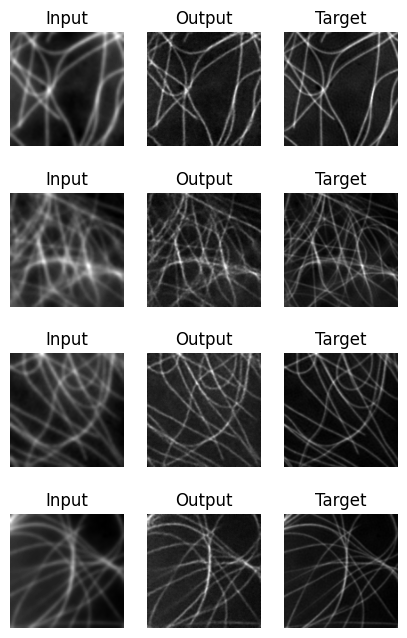


Epoch 13/30
__________
Batch 1/630: Train loss: 0.0375
Batch 201/630: Train loss: 0.0398
Batch 401/630: Train loss: 0.0611
Batch 601/630: Train loss: 0.0381
----------
Epoch 13/30 : Train loss: 0.0479, Time taken: 0:05:14.827415


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.31it/s]


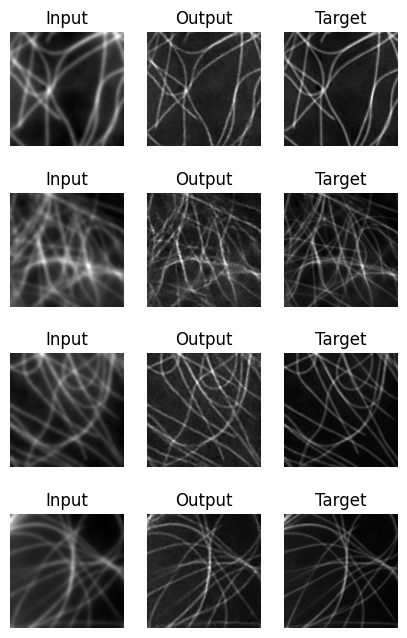


Epoch 14/30
__________
Batch 1/630: Train loss: 0.0595
Batch 201/630: Train loss: 0.0387
Batch 401/630: Train loss: 0.0621
Batch 601/630: Train loss: 0.0329
----------
Epoch 14/30 : Train loss: 0.0469, Time taken: 0:05:11.561718


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.93it/s]


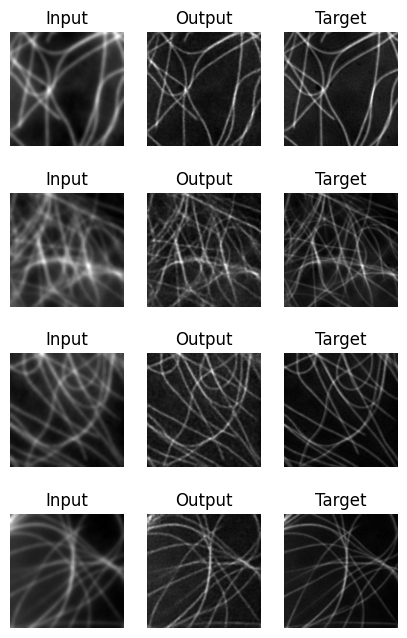


Epoch 15/30
__________
Batch 1/630: Train loss: 0.0327
Batch 201/630: Train loss: 0.0427
Batch 401/630: Train loss: 0.0460
Batch 601/630: Train loss: 0.0451
----------
Epoch 15/30 : Train loss: 0.0459, Time taken: 0:05:13.736628


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.99it/s]


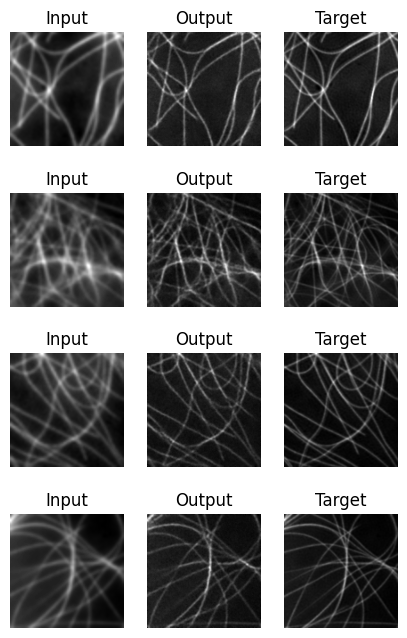


Epoch 16/30
__________
Batch 1/630: Train loss: 0.0371
Batch 201/630: Train loss: 0.0537
Batch 401/630: Train loss: 0.0508
Batch 601/630: Train loss: 0.0278
----------
Epoch 16/30 : Train loss: 0.0458, Time taken: 0:05:10.856517


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.32it/s]


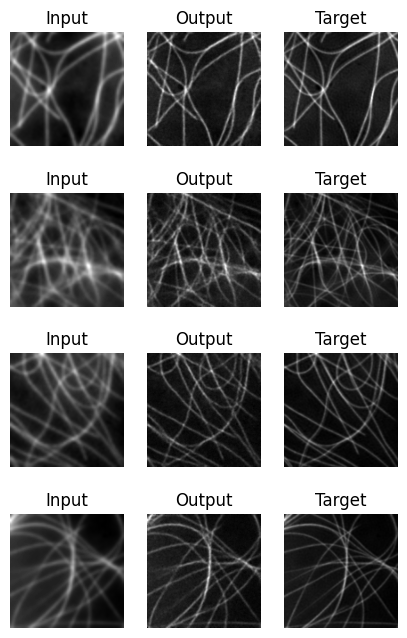


Epoch 17/30
__________
Batch 1/630: Train loss: 0.0402
Batch 201/630: Train loss: 0.0669
Batch 401/630: Train loss: 0.0398
Batch 601/630: Train loss: 0.0404
----------
Epoch 17/30 : Train loss: 0.0453, Time taken: 0:05:18.135220


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 203.13it/s]


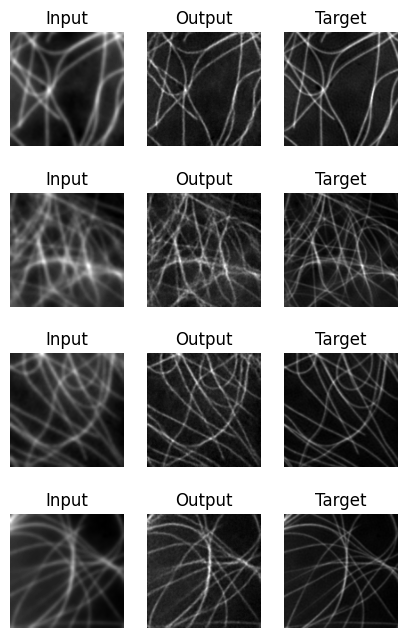


Epoch 18/30
__________
Batch 1/630: Train loss: 0.0644
Batch 201/630: Train loss: 0.0304
Batch 401/630: Train loss: 0.0338
Batch 601/630: Train loss: 0.0482
----------
Epoch 18/30 : Train loss: 0.0450, Time taken: 0:05:19.005620


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.52it/s]


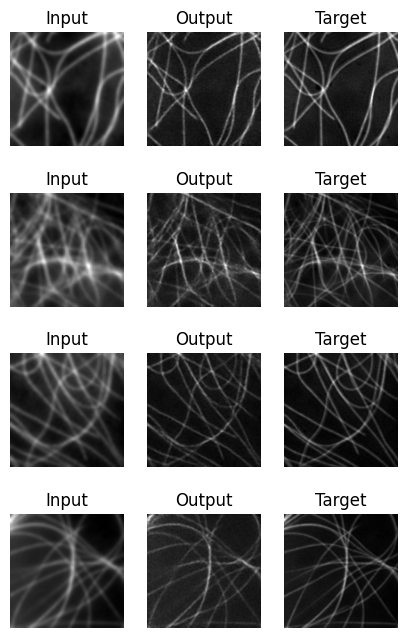


Epoch 19/30
__________
Batch 1/630: Train loss: 0.0627
Batch 201/630: Train loss: 0.0442
Batch 401/630: Train loss: 0.0410
Batch 601/630: Train loss: 0.0616
----------
Epoch 19/30 : Train loss: 0.0443, Time taken: 0:05:20.329075


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.24it/s]


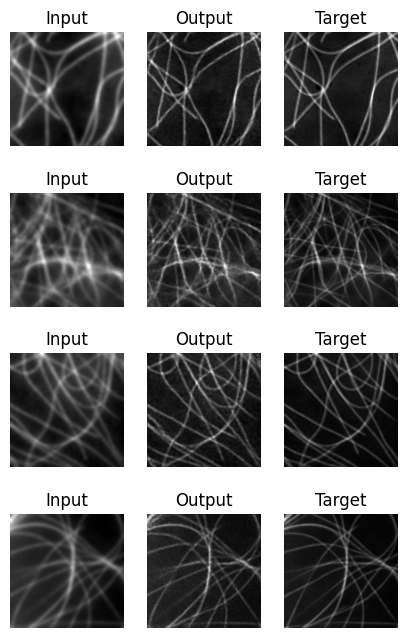


Epoch 20/30
__________
Batch 1/630: Train loss: 0.0460
Batch 201/630: Train loss: 0.0431
Batch 401/630: Train loss: 0.0364
Batch 601/630: Train loss: 0.0625
----------
Epoch 20/30 : Train loss: 0.0444, Time taken: 0:05:14.196085


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.08it/s]


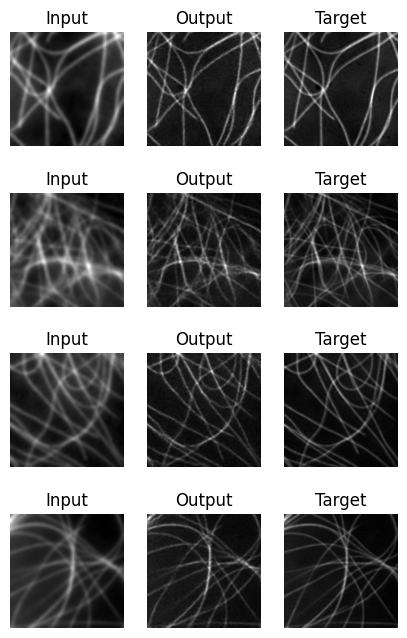


Epoch 21/30
__________
Batch 1/630: Train loss: 0.0427
Batch 201/630: Train loss: 0.0660
Batch 401/630: Train loss: 0.0539
Batch 601/630: Train loss: 0.0532
----------
Epoch 21/30 : Train loss: 0.0441, Time taken: 0:05:14.874032


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 201.74it/s]


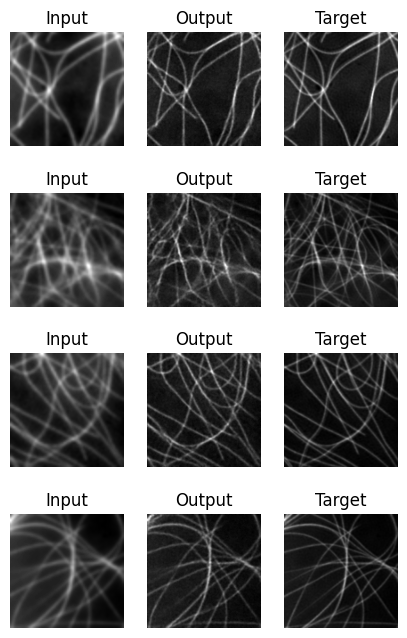


Epoch 22/30
__________
Batch 1/630: Train loss: 0.0492
Batch 201/630: Train loss: 0.0550
Batch 401/630: Train loss: 0.0256
Batch 601/630: Train loss: 0.0399
----------
Epoch 22/30 : Train loss: 0.0434, Time taken: 0:05:13.352788


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 203.25it/s]


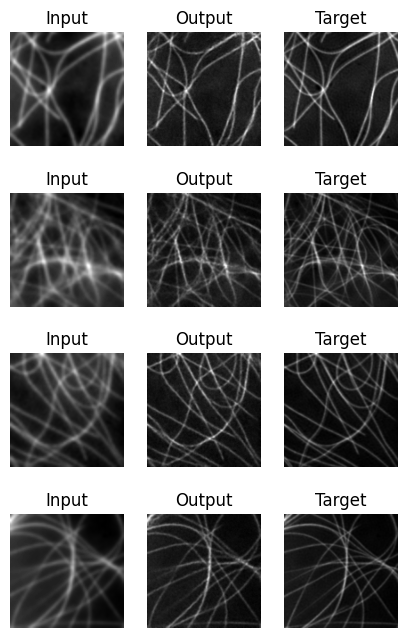


Epoch 23/30
__________
Batch 1/630: Train loss: 0.0294
Batch 201/630: Train loss: 0.0311
Batch 401/630: Train loss: 0.0500
Batch 601/630: Train loss: 0.0268
----------
Epoch 23/30 : Train loss: 0.0436, Time taken: 0:05:15.923544


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.27it/s]


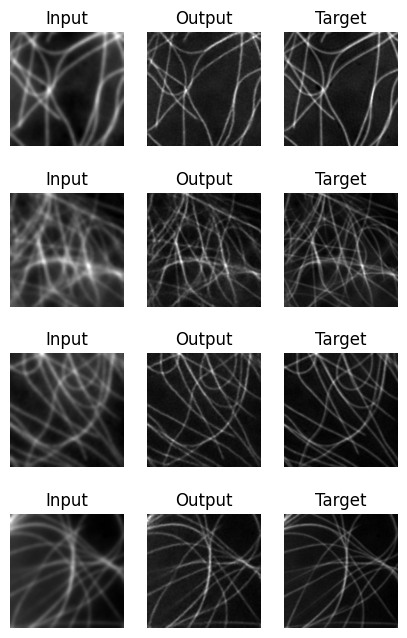


Epoch 24/30
__________
Batch 1/630: Train loss: 0.0439
Batch 201/630: Train loss: 0.0382
Batch 401/630: Train loss: 0.0395
Batch 601/630: Train loss: 0.0367
----------
Epoch 24/30 : Train loss: 0.0436, Time taken: 0:05:17.458632


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.56it/s]


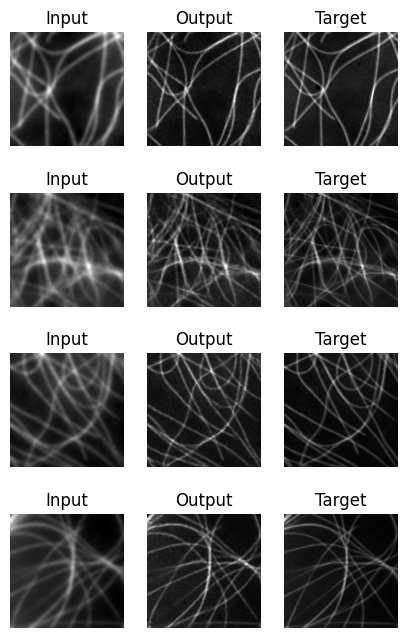


Epoch 25/30
__________
Batch 1/630: Train loss: 0.0272
Batch 201/630: Train loss: 0.0312
Batch 401/630: Train loss: 0.0316
Batch 601/630: Train loss: 0.0377
----------
Epoch 25/30 : Train loss: 0.0427, Time taken: 0:05:17.440647


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.68it/s]


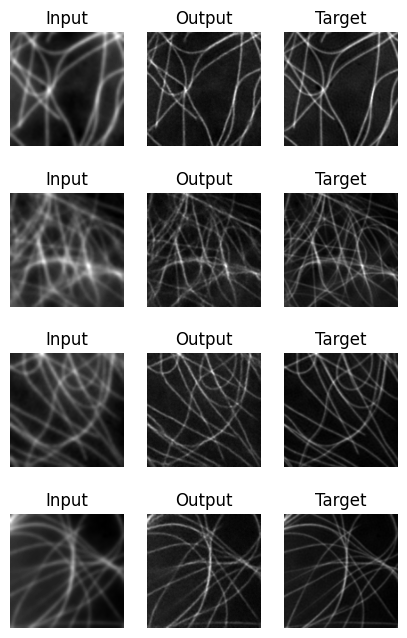


Epoch 26/30
__________
Batch 1/630: Train loss: 0.0505
Batch 201/630: Train loss: 0.0452
Batch 401/630: Train loss: 0.0334
Batch 601/630: Train loss: 0.0409
----------
Epoch 26/30 : Train loss: 0.0432, Time taken: 0:05:22.709795


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 201.83it/s]


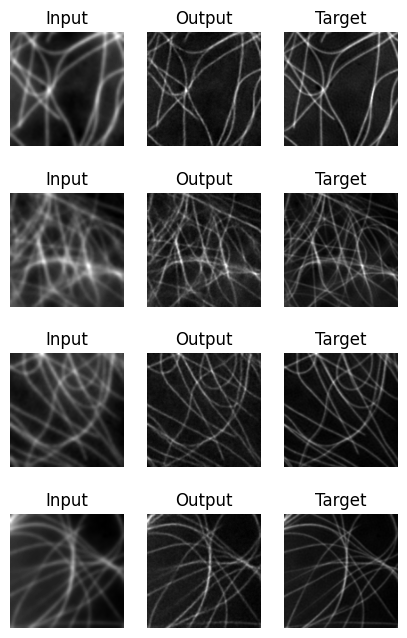


Epoch 27/30
__________
Batch 1/630: Train loss: 0.0279
Batch 201/630: Train loss: 0.0587
Batch 401/630: Train loss: 0.0300
Batch 601/630: Train loss: 0.0393
----------
Epoch 27/30 : Train loss: 0.0422, Time taken: 0:05:16.937742


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.48it/s]


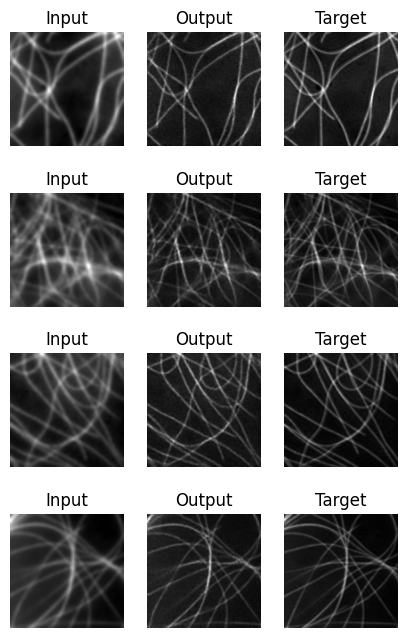


Epoch 28/30
__________
Batch 1/630: Train loss: 0.0448
Batch 201/630: Train loss: 0.0678
Batch 401/630: Train loss: 0.0492
Batch 601/630: Train loss: 0.0352
----------
Epoch 28/30 : Train loss: 0.0434, Time taken: 0:05:10.381538


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.57it/s]


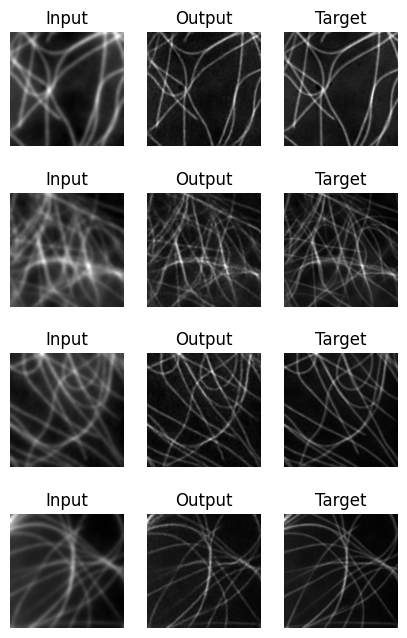


Epoch 29/30
__________
Batch 1/630: Train loss: 0.0637
Batch 201/630: Train loss: 0.0596
Batch 401/630: Train loss: 0.0436
Batch 601/630: Train loss: 0.0447
----------
Epoch 29/30 : Train loss: 0.0432, Time taken: 0:05:44.673042


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 203.27it/s]


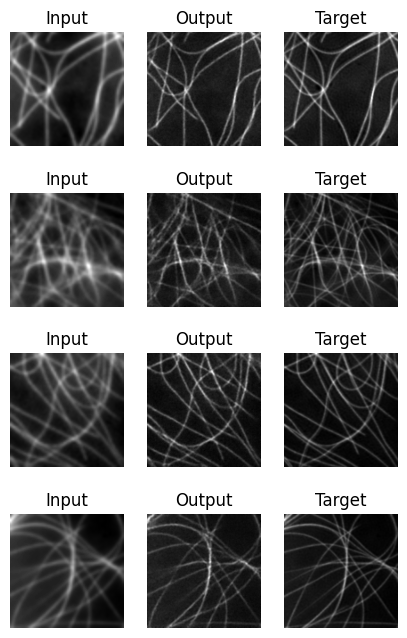


Epoch 30/30
__________
Batch 1/630: Train loss: 0.0489
Batch 201/630: Train loss: 0.0351
Batch 401/630: Train loss: 0.0272
Batch 601/630: Train loss: 0.0272
----------
Epoch 30/30 : Train loss: 0.0425, Time taken: 0:05:51.483026


U-Net inference: 100%|█████████████████████| 2000/2000 [00:09<00:00, 202.97it/s]


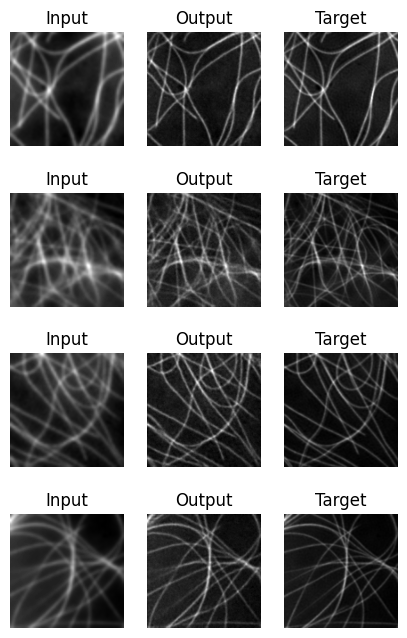

In [16]:
import time
from datetime import timedelta

epochs = 30

train_loss = []

for epoch in range(epochs):
    unet.train()
    
    start_time = time.time()

    num_batches = len(train_loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)

    running_loss = 0.0
    for batch_idx, (input_images, target_images) in enumerate(
        train_loader, start=0):
        
        x_t, t, noise = prepare_data(input_images, target_images)

        outputs = unet(x=x_t, t=t)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    # Save the loss
    train_loss.append(running_loss / len(train_loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
        + f"Train loss: {train_loss[-1]:.4f}, " 
        + f"Time taken: {timedelta(seconds=end_time - start_time)}")

    unet.eval()
    n_images = 4

    test_loader = DataLoader(test_dataset, batch_size=n_images, shuffle=False)

    for batch_idx, (test_input_images,
                     test_target_images) in enumerate(test_loader):

        generated_images = diffusion.reverse_diffusion(
            model=unet,
            n_images=n_images,
            n_channels=1,
            position_encoding_dim=position_encoding_dim,
            position_encoding_function=positional_encoding,
            input_image=test_input_images[:n_images],
            save_time_steps=[0],
        )

        break

    fig = plt.figure(figsize=(5, 8))
    n_images = test_input_images.shape[0]
    for i in range(n_images):
        image_diff_traj = generated_images[i]
        low_res_image = test_input_images[i]
        high_res_image = image_diff_traj[-1]
        target_image = test_target_images[i]

        plt.subplot(n_images, 3, i * 3 + 1)
        plt.title("Input")
        plt.imshow(low_res_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.axis("off")
        
        plt.subplot(n_images, 3, i * 3 + 2)
        plt.title("Output")
        plt.imshow(high_res_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.axis("off")
        
        plt.subplot(n_images, 3, i * 3 + 3)
        plt.title("Target")
        plt.imshow(target_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.axis("off")

    plt.show()
    plt.close(fig)

### Plot losses

We now plot the losses for the training and validation datasets.

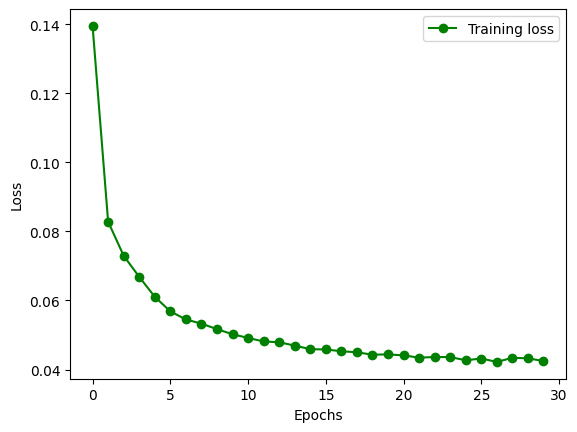

In [18]:
plt.figure()
plt.plot(train_loss, "g-o", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()